# LCA Exploratory Analysis - Stats and Visualizations

Now that I have a cleaned and prepped dataset, let's poke around and see what we can learn. I'm particularly curious about the wages given to H1B applicants vs. the national average, the companies hiring the most foreigners, and what parts of the country they tend to work in.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline


f = open("Prepped_LCA.csv", "r")
LCA_df = pd.read_csv(f, index_col=0)
f.close()

In [2]:
print LCA_df.dtypes

LCA_CASE_NUMBER                    object
STATUS                             object
LCA_CASE_SUBMIT                    object
DECISION_DATE                      object
LCA_CASE_EMPLOYMENT_START_DATE     object
LCA_CASE_EMPLOYMENT_END_DATE       object
LCA_CASE_EMPLOYER_NAME             object
LCA_CASE_EMPLOYER_ADDRESS          object
LCA_CASE_EMPLOYER_CITY             object
LCA_CASE_EMPLOYER_STATE            object
LCA_CASE_EMPLOYER_POSTAL_CODE       int64
LCA_CASE_SOC_CODE                  object
LCA_CASE_SOC_NAME                  object
LCA_CASE_JOB_TITLE                 object
LCA_CASE_WAGE_RATE_FROM           float64
LCA_CASE_WAGE_RATE_UNIT            object
FULL_TIME_POS                      object
LCA_CASE_WORKLOC1_CITY             object
LCA_CASE_WORKLOC1_STATE            object
PW_1                              float64
PW_UNIT_1                          object
LCA_CASE_NAICS_CODE               float64
dtype: object


I'll start by just plotting histograms of yearly and hourly wages. For the yearly wages, I'll use a log10 trasnform to normalize the distribution.

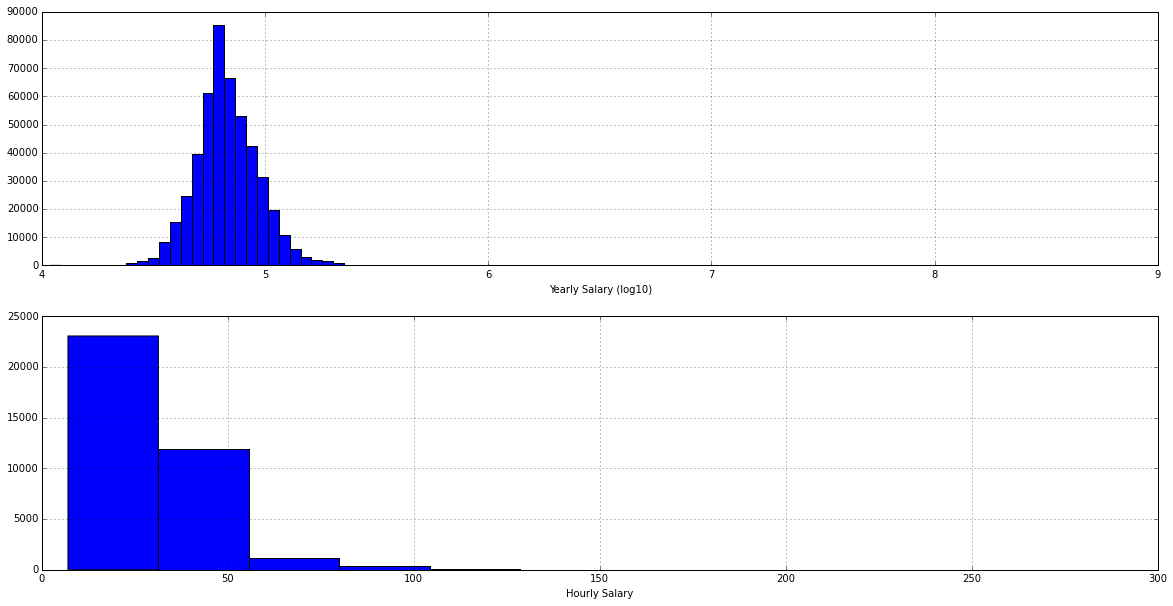

In [100]:
yearly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Year"]
hourly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Hour"]

log10_yearly_wages = np.log10(yearly_wages)  # yearly wages can vary much more than hourly ones.

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(log10_yearly_wages, bins=100)
plt.xlabel("Yearly Salary (log10)")
plt.grid(True)

plt.subplot(212)
plt.hist(hourly_wages.values, bins=10)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

There are a few extreme outliers in the yearly group, which makes sense. However, the hourly wages have some values that are obviously supposed to be yearly, or are missing decimal points.

In [4]:
for index, row in LCA_df.iterrows():
    if row[20] == "Hour":
        if row[19] > 10000:  # "Hourly" wages greater than $10,000 are probably yearly. 
            LCA_df.loc[index, "PW_UNIT_1"] = "Year"
        elif row[19] > 1000:  # Wages greter than $1000, but less than $10,000 are missing a decimal.
            LCA_df.loc[index, "PW_1"] = row[19]/100.
            

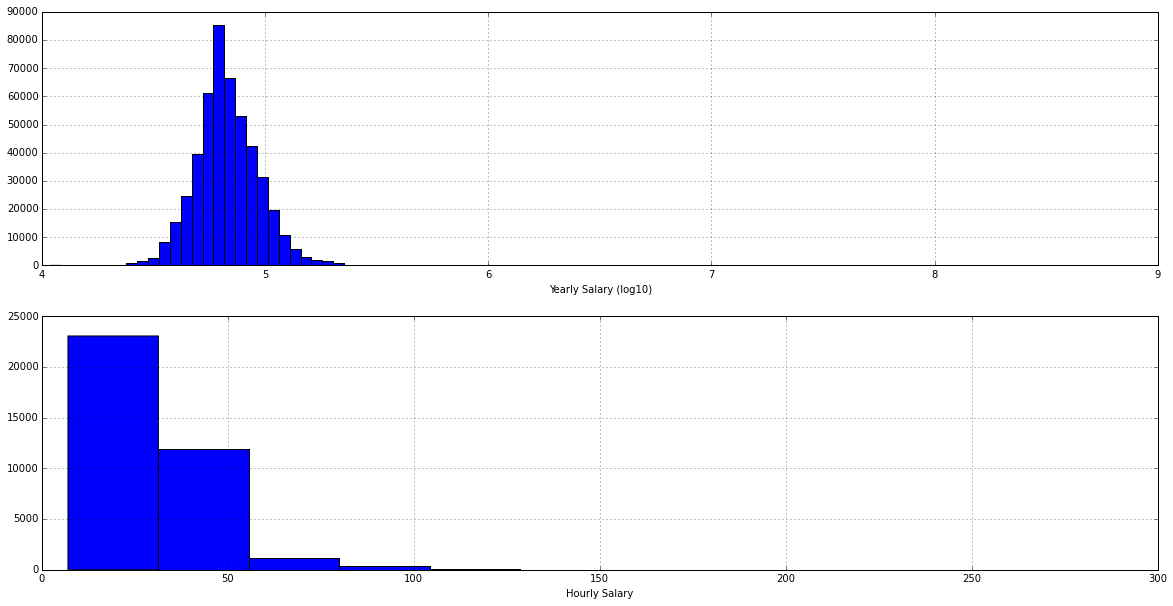

In [101]:
yearly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Year"]
hourly_wages = LCA_df["PW_1"][LCA_df.PW_UNIT_1 == "Hour"]

log10_yearly_wages = np.log10(yearly_wages)  # yearly wages can vary much more than hourly ones.

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(log10_yearly_wages, bins=100)
plt.xlabel("Yearly Salary (log10)")
plt.grid(True)

plt.subplot(212)
plt.hist(hourly_wages.values, bins=10)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

That looks much better. Let's try again without the top 1%.

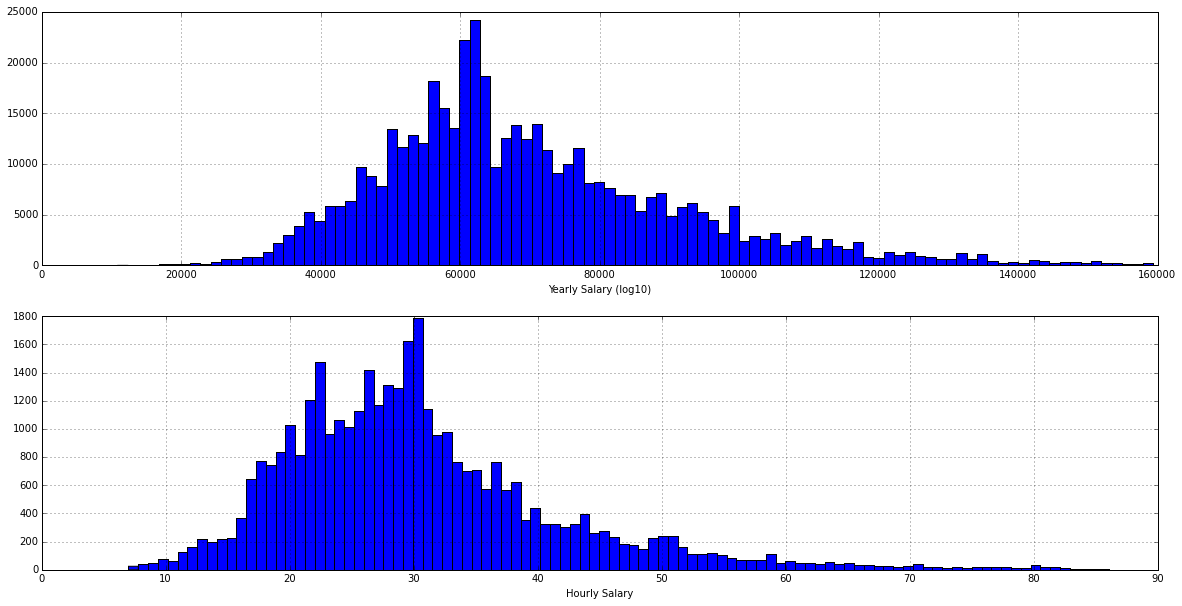

In [6]:
the_99_percent_yearly = yearly_wages[yearly_wages < yearly_wages.quantile(.99)]
the_99_percent_hourly = hourly_wages[hourly_wages < hourly_wages.quantile(.99)]

plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(the_99_percent_yearly, bins=100)
plt.xlabel("Yearly Salary (log10)")
plt.grid(True)

plt.subplot(212)
plt.hist(the_99_percent_hourly.values, bins=100)
plt.xlabel("Hourly Salary")
plt.grid(True)

plt.show()

It appears that H1B applicant salaries tend to skew right. It also seems that they are paid considerably higher than the national median of ~$51,000 anually (we can confirm this). This is expected though, since companies wouldn't bother sponsoring just anyone to get an H1B. Though it's not fair to compare all H1B applicants to all US residents, it would be interesting to see the difference in wage when taking account of both job title and work location. For now, let's get some stats on these sets of data.

In [7]:
print the_99_percent_yearly.describe() 
print the_99_percent_hourly.describe()

count    472833.000000
mean      69789.649309
std       21825.619423
min       10899.000000
25%       55370.000000
50%       65250.000000
75%       80995.000000
max      159349.000000
Name: PW_1, dtype: float64
count    36227.000000
mean        30.441881
std         11.237189
min          7.010000
25%         22.770000
50%         28.860000
75%         35.310000
max         86.080000
Name: PW_1, dtype: float64


The salaried workers are the overwhelming majority, and they have a median salary over $10,000 above the national. I wonder what the typical delta between H1B wages and national averages are. I have two datasets from the Bureau of Labor Statistics, national and state, that give the wage information of each occupation (listed by SOC_CODE). At this point, I don't want to look at denied requests (the whole point of LCA is making sure American wages aren't being undercut). I'll also remove the top 1% as those truly are outliers.

In [71]:
certified_LCA_df = LCA_df[LCA_df.STATUS.str.contains("CERTIFIED")][LCA_df["PW_1"] < LCA_df["PW_1"].quantile(.99)]

f_national = open("National_2014_Wages.xlsx", "r")
f_state = open("State_2014_Wages.xlsx", "r")

national_df = pd.read_excel(f_national, na_values=["*"])  # These datasets use "*" for null values
state_df = pd.read_excel(f_state, na_values=["*", "#"])  # This one also uses "#" for extremely high values

In [61]:
print "National:", national_df.columns
print "State:", state_df.columns

National: Index([ u'OCC_CODE', u'OCC_TITLE', u'OCC_GROUP',   u'TOT_EMP',  u'EMP_PRSE',
          u'H_MEAN',    u'A_MEAN', u'MEAN_PRSE',   u'H_PCT10',   u'H_PCT25',
        u'H_MEDIAN',   u'H_PCT75',   u'H_PCT90',   u'A_PCT10',   u'A_PCT25',
        u'A_MEDIAN',   u'A_PCT75',   u'A_PCT90',    u'ANNUAL',    u'HOURLY'],
      dtype='object')
State: Index([     u'AREA',        u'ST',     u'STATE',  u'OCC_CODE', u'OCC_TITLE',
       u'OCC_GROUP',   u'TOT_EMP',  u'EMP_PRSE', u'JOBS_1000',     u'LOC_Q',
          u'H_MEAN',    u'A_MEAN', u'MEAN_PRSE',   u'H_PCT10',   u'H_PCT25',
        u'H_MEDIAN',   u'H_PCT75',   u'H_PCT90',   u'A_PCT10',   u'A_PCT25',
        u'A_MEDIAN',   u'A_PCT75',   u'A_PCT90',    u'ANNUAL',    u'HOURLY'],
      dtype='object')


I'll be performing joins using these datasets, so I need to subset them to just the columns I'll be looking at and rename them.

In [72]:
national_columns = ["OCC_CODE", "H_MEAN", "A_MEAN"]
state_columns = ["ST", "OCC_CODE", "H_MEAN", "A_MEAN"]

national_df = national_df[national_columns]
state_df = state_df[state_columns]

national_df.columns = ["SOC_CODE", "NATIONAL_H_MEAN", "NATIONAL_A_MEAN"]
state_df.columns = ["STATE", "SOC_CODE", "STATE_H_MEAN", "STATE_A_MEAN"]

In [75]:
delta_df = pd.merge(certified_LCA_df, national_df, left_on="LCA_CASE_SOC_CODE", right_on="SOC_CODE")
delta_df = pd.merge(delta_df, state_df, left_on=["LCA_CASE_WORKLOC1_STATE", "LCA_CASE_SOC_CODE"], 
                 right_on=["STATE", "SOC_CODE"])

delta_df["NATIONAL_DELTA"] = np.nan  # add two columns to fill in
delta_df["STATE_DELTA"] = np.nan

Now that I have all the requisite data on one dataframe, I can calculate the delta as a percentile.

In [91]:
pd.set_option('chained_assignment',None)  # pandas freaks out over these next operations, but they are valid.

delta_df["NATIONAL_DELTA"][delta_df["PW_UNIT_1"] == "Hour"] = delta_df["PW_1"]/delta_df["NATIONAL_H_MEAN"] - 1
delta_df["NATIONAL_DELTA"][delta_df["PW_UNIT_1"] == "Year"] = delta_df["PW_1"]/delta_df["NATIONAL_A_MEAN"] - 1
delta_df["STATE_DELTA"][delta_df["PW_UNIT_1"] == "Hour"] = delta_df["PW_1"]/delta_df["STATE_H_MEAN"] - 1
delta_df["STATE_DELTA"][delta_df["PW_UNIT_1"] == "Year"] = delta_df["PW_1"]/delta_df["STATE_A_MEAN"] - 1

print delta_df.tail()

           LCA_CASE_NUMBER     STATUS      LCA_CASE_SUBMIT  \
472740  I-203-14149-120922  CERTIFIED  2014-05-30 14:10:49   
472741  I-203-14258-006752  CERTIFIED  2014-09-15 14:26:23   
472742  I-203-14160-723112  CERTIFIED  2014-06-11 17:10:48   
472743  I-203-14211-765307  CERTIFIED  2014-07-30 13:29:14   
472744  I-203-14237-290269  CERTIFIED  2014-08-27 02:11:07   

              DECISION_DATE LCA_CASE_EMPLOYMENT_START_DATE  \
472740  2014-06-05 22:01:51            2014-06-23 00:00:00   
472741  2014-09-19 22:01:38            2014-11-04 00:00:00   
472742  2014-06-17 22:00:33            2014-07-14 00:00:00   
472743  2014-08-07 22:00:56            2014-07-30 00:00:00   
472744  2014-09-03 22:01:04            2014-09-11 00:00:00   

       LCA_CASE_EMPLOYMENT_END_DATE                LCA_CASE_EMPLOYER_NAME  \
472740          2014-12-31 00:00:00            SITKA CONSERVATION SOCIETY   
472741          2016-11-04 00:00:00      ARIZONA GAME AND FISH DEPARTMENT   
472742          2016-07

Looks good - now lets plot them and see what happens!

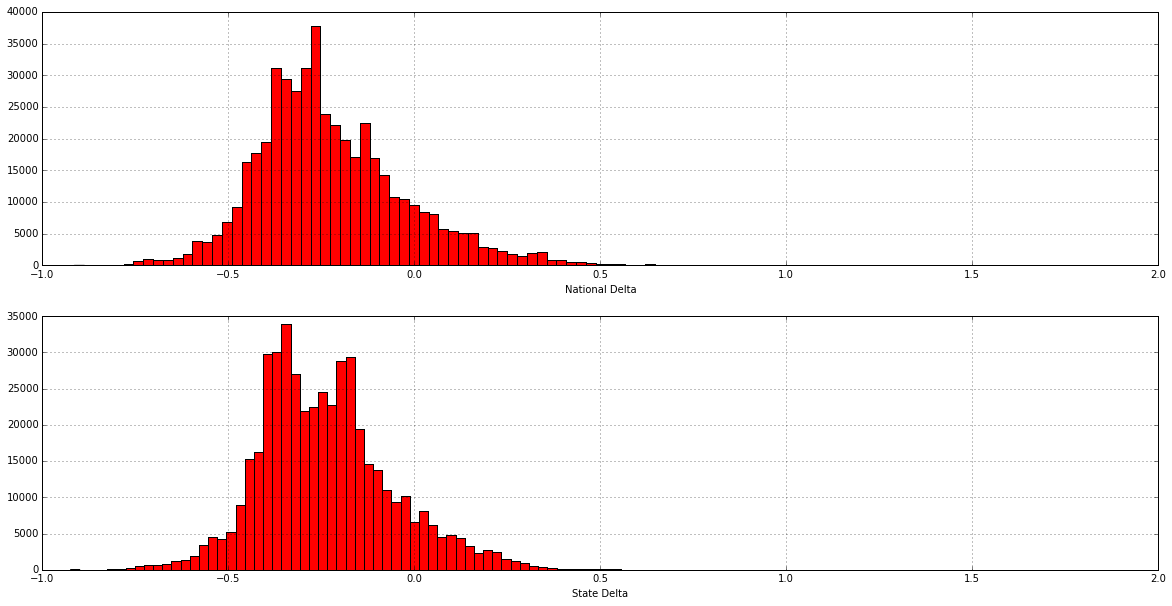

In [105]:
national_delta = delta_df["NATIONAL_DELTA"].dropna()
state_delta = delta_df["STATE_DELTA"].dropna()


plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(national_delta, bins=100, color = "r")
plt.xlabel("National Delta")
plt.grid(True)

plt.subplot(212)
plt.hist(state_delta.values, bins=100, color = "r")
plt.xlabel("State-Adjusted Delta")
plt.grid(True)

plt.show()

In [96]:
# What's going on with that extreme value? I already filtered out the top 1%...

print delta_df[delta_df["NATIONAL_DELTA"] > 3].values

[['I-203-13296-958927' 'CERTIFIED' '2013-10-23 08:30:20'
  '2013-11-06 22:01:24' '2013-12-01 00:00:00' '2015-12-01 00:00:00'
  'BOX PLUS LLC' '41-21 23RD ST' 'LONG ISLAND CITY' 'NY' 11101 '27-1024'
  'Graphic Designers' 'PRODUCT DESIGNER' 100.0 'Hour' 'N'
  'LONG ISLAND CITY' 'NY' 100.0 'Hour' 541430.0 u'27-1024' 24.36 50670.0
  u'NY' u'27-1024' 29.11 60560.0 3.1050903119868636 2.4352456200618344]]


After investigating this company, I found NO information whatsoever other than data from other H1B and LCA data sources. Suspicious...

I'll drop it from the datafram and replot for a clearer picture.

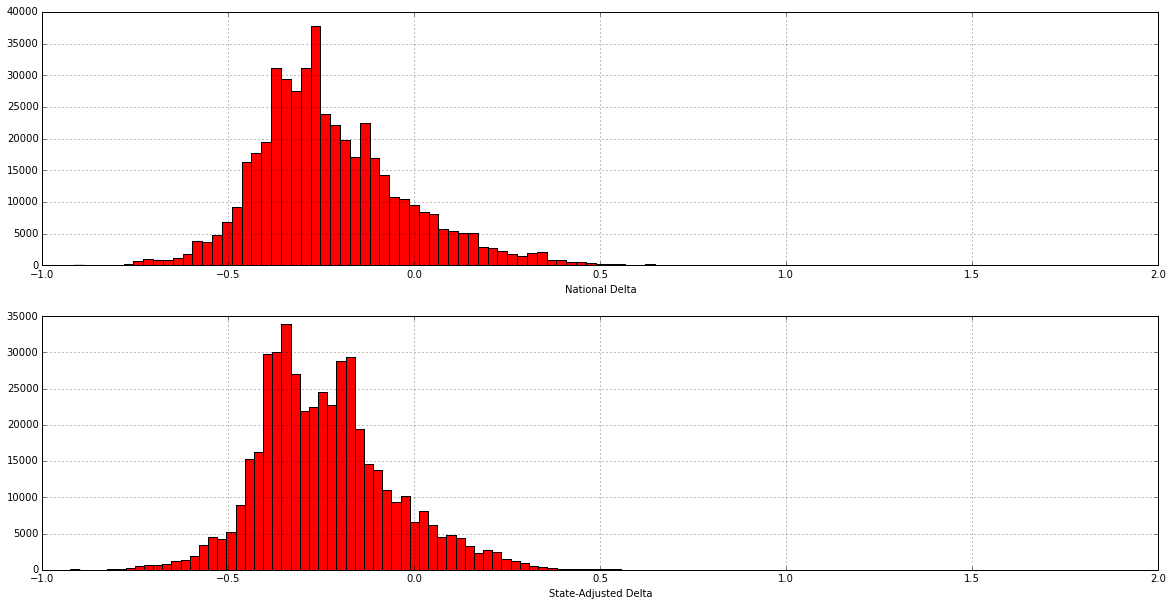

Mean National Delta: -0.223855233752
Mean State-Adjusted Delta: -0.238292918474


In [107]:
delta_df = delta_df[delta_df["NATIONAL_DELTA"] < 3]

national_delta = delta_df["NATIONAL_DELTA"].dropna()
state_delta = delta_df["STATE_DELTA"].dropna()


plt.figure(figsize=(20,10))

plt.subplot(211)
plt.hist(national_delta, bins=100, color = "r")
plt.xlabel("National Delta")
plt.grid(True)

plt.subplot(212)
plt.hist(state_delta.values, bins=100, color = "r")
plt.xlabel("State-Adjusted Delta")
plt.grid(True)

plt.show()

print "Mean National Delta:", national_delta.mean()
print "Mean State-Adjusted Delta:", state_delta.mean()


With several hundred thousand datapoints, we don't need a T-Test to establish that H1B applicants are clearly getting paid less on average for the same job than their US resident counterparts. That said, are there any states or industries that pay immigrants particularly well? I'll use the STATE_DELTA, since it alread has an additional layer of information built in.

In [127]:
delta_grouped_by_state = delta_df.groupby(["STATE"])
print delta_grouped_by_state["STATE_DELTA"].mean().order("STATE_DELTA").dropna()

STATE
AL   -0.319356
VA   -0.282085
NM   -0.279313
MD   -0.278361
NJ   -0.266543
DC   -0.265231
CO   -0.262386
TX   -0.260786
RI   -0.256793
NY   -0.255790
MO   -0.254512
MA   -0.254481
OK   -0.253989
CT   -0.247797
ND   -0.244549
IL   -0.244436
WY   -0.244070
MS   -0.243484
FL   -0.241597
HI   -0.241441
WV   -0.241345
AK   -0.240939
LA   -0.239579
GA   -0.239166
AZ   -0.237386
GU   -0.237067
SC   -0.236697
ME   -0.234831
NC   -0.233914
PA   -0.232873
AR   -0.232434
UT   -0.232244
MI   -0.231484
VI   -0.229614
KS   -0.225084
IN   -0.224649
NE   -0.222767
TN   -0.222405
IA   -0.221972
DE   -0.218487
NH   -0.216854
OH   -0.213234
MT   -0.211592
CA   -0.211413
MN   -0.209126
ID   -0.204677
WA   -0.204332
NV   -0.204100
KY   -0.198641
VT   -0.198240
PR   -0.197000
WI   -0.190762
SD   -0.181550
OR   -0.165365
Name: STATE_DELTA, dtype: float64


Well, Alabama seems to be the worst place to immigrate to if money is your priority. Oregon seems like a safe bet though. What about industry? 

In [144]:
# Given the nature of the data, many industry codes will be wrong.
# I'm only going to look at industries with more than 00 applicants.

delta_grouped_by_industry = delta_df.groupby(["LCA_CASE_NAICS_CODE"])
valid_industries = delta_grouped_by_industry.size()[delta_grouped_by_industry.size() > 100].keys()

valid_industry_df = delta_df[delta_df["LCA_CASE_NAICS_CODE"].isin(valid_industries)]
delta_grouped_by_industry = valid_industry_df.groupby(["LCA_CASE_NAICS_CODE"])

print delta_grouped_by_industry["STATE_DELTA"].mean().order("STATE_DELTA").dropna()


LCA_CASE_NAICS_CODE
6221     -0.469938
611300   -0.441932
61131    -0.429452
6211     -0.419022
611310   -0.413688
622110   -0.401971
4243     -0.397740
6113     -0.396689
424990   -0.389681
621210   -0.389501
62111    -0.375096
622310   -0.372634
541712   -0.355789
424330   -0.350192
514511   -0.345223
423940   -0.339299
423990   -0.336239
621112   -0.336230
511110   -0.335943
621111   -0.333489
54111    -0.333361
611630   -0.329385
711410   -0.323162
541700   -0.316844
621399   -0.316678
5411     -0.315294
621498   -0.314517
53131    -0.312998
54511    -0.312997
541320   -0.312048
            ...   
5191     -0.120380
334510   -0.120195
2111     -0.117560
551112   -0.117355
524130   -0.113095
311999   -0.111825
453210   -0.110718
333295   -0.107471
551114   -0.100206
444110   -0.094967
334110   -0.093128
51721    -0.092791
448140   -0.086064
325510   -0.085497
334119   -0.082116
452910   -0.080735
452112   -0.077357
521110   -0.064794
522230   -0.062108
336100   -0.061961
522320   -0

In [159]:
print delta_df[delta_df["LCA_CASE_NAICS_CODE"] == 316219][delta_df["LCA_CASE_EMPLOYER_CITY"] == "BEAVERTON"]

           LCA_CASE_NUMBER               STATUS      LCA_CASE_SUBMIT  \
143564  I-200-11186-178460  CERTIFIED-WITHDRAWN  2011-11-17 17:37:27   
143565  I-200-11307-805974  CERTIFIED-WITHDRAWN  2011-11-18 16:21:54   
143568  I-200-12052-161263  CERTIFIED-WITHDRAWN  2012-03-02 18:04:52   
143587  I-200-13260-428708            CERTIFIED  2013-09-24 18:11:57   
143604  I-200-13291-900169            CERTIFIED  2013-10-22 18:46:41   
143608  I-200-13297-043958            CERTIFIED  2013-10-26 12:58:03   
143687  I-200-14022-594940            CERTIFIED  2014-02-06 15:44:41   
143721  I-200-14045-132414  CERTIFIED-WITHDRAWN  2014-02-18 15:28:16   
143723  I-200-14045-827842  CERTIFIED-WITHDRAWN  2014-02-18 15:35:44   
143739  I-200-14055-206916            CERTIFIED  2014-02-25 19:23:53   
143740  I-200-14056-265004            CERTIFIED  2014-02-27 17:46:02   
143807  I-200-14076-832460            CERTIFIED  2014-05-22 18:27:50   
143833  I-200-14092-583166            CERTIFIED  2014-04-02 20:1

In [165]:
delta_df2 = delta_df

unwanted_columns = ["STATUS", "LCA_CASE_SUBMIT", "DECISION_DATE", "LCA_CASE_EMPLOYMENT_START_DATE", 
                   "LCA_CASE_EMPLOYMENT_END_DATE", "SOC_CODE_x", "SOC_CODE_y"]

delta_df2 = delta_df2.drop(unwanted_columns, axis=1)

print delta_df2[delta_df2["LCA_CASE_EMPLOYER_NAME"].isin(["NIKE INC", "NIKE USA INC"])]

           LCA_CASE_NUMBER LCA_CASE_EMPLOYER_NAME LCA_CASE_EMPLOYER_ADDRESS  \
143564  I-200-11186-178460               NIKE INC        ONE BOWERMAN DRIVE   
143565  I-200-11307-805974               NIKE INC        ONE BOWERMAN DRIVE   
143568  I-200-12052-161263               NIKE INC        ONE BOWERMAN DRIVE   
143587  I-200-13260-428708               NIKE INC        ONE BOWERMAN DRIVE   
143604  I-200-13291-900169               NIKE INC        ONE BOWERMAN DRIVE   
143608  I-200-13297-043958               NIKE INC        ONE BOWERMAN DRIVE   
143687  I-200-14022-594940               NIKE INC        ONE BOWERMAN DRIVE   
143721  I-200-14045-132414               NIKE INC        ONE BOWERMAN DRIVE   
143723  I-200-14045-827842               NIKE INC        ONE BOWERMAN DRIVE   
143739  I-200-14055-206916               NIKE INC        ONE BOWERMAN DRIVE   
143740  I-200-14056-265004               NIKE INC        ONE BOWERMAN DRIVE   
143807  I-200-14076-832460               NIKE INC   